In [1]:
%matplotlib inline
#%matplotlib notebook
#%matplotlib notebook
import re
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
sns.set(color_codes=True)

from time import time
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import os; import json; import fileinput
#from numba import jit

In [34]:
st = time()
fileinput.close() # sometimes fileinput is already active

def load_file(filename, transformer=None, max_lines = 50000):
    data_dir = "yelp_dataset_challenge_round9"
    filepath = os.path.join(data_dir, filename)

    data = []
    for line in fileinput.input(filepath):
        d = json.loads(line)
                
        if transformer:
            d = transformer(d)

        data.append(d)
        if len(data) > max_lines: break
            
    fileinput.close()
    return pd.DataFrame(data)

# These functions transform some values for later
def transf_checkin(d):
    d['n_time'] = len(d['time'])
    return d

def transf_review(d):
    d['date'] = datetime.strptime(d['date'], '%Y-%m-%d')
    d['weekday'] = d['date'].weekday()
    return d

def transf_user(d):    
    d['n_friends'] = len(d['friends'])
    d['n_elite'] = len(d['elite'])
    del d['friends']
    del d['elite']
    #del d['compliment_writer'] # are there more than one type?
    return d

df_bus = load_file("yelp_academic_dataset_business.json", None, 1500000)
df_checkin = load_file("yelp_academic_dataset_checkin.json", transf_checkin)
df_review = load_file("yelp_academic_dataset_review.json", transf_review, 1500000)
df_tip = load_file("yelp_academic_dataset_tip.json")
df_user = load_file("yelp_academic_dataset_user.json", transf_user)

def hours_to_matrix(hours):
    mat = np.zeros((7,), dtype=np.int8)
    if hours is None: 
        return mat
    day = 0
    for h in hours:
        length = 0
        rr = re.findall("[.]?[\d]+(?:,\d\d\d)*[\.]?\d*(?:[eE]\d+)?", h)
        if len(rr):
            length = int(rr[2]) - int(rr[0])
            if length < 0:
                length += 24
                
        if h.startswith('Mon'): day = 0
        if h.startswith('Tue'): day = 1
        if h.startswith('Wed'): day = 2
        if h.startswith('Thu'): day = 3
        if h.startswith('Fri'): day = 4
        if h.startswith('Sat'): day = 5
        if h.startswith('Sun'): day = 6
        mat[day] = length
    return mat

# add attributes columns
# TODO unfinished for "GoodForMeal", "Ambience"
def add_attribute_cols(attr):
    s = {}
    if attr is not None:
        for a in attr:
            t = a.split(':')
            if "True" in t[1]:
                s["attr_" + t[0].strip()] = 1
            else:
                s["attr_" + t[0].strip()] = 0
            if "RestaurantsPriceRange2" in a:
                s["attr_RestaurantsPriceRange2"] = int(t[1])
            if "WiFi: free" in a:
                s["attr_WiFi"] = 1
            if "BusinessParking" in a: # improvable
                counter = 0
                for b in ["'garage': True", "'street': True", "'lot': True", "'valet': True"]:
                    if b in a:
                        counter += 1
                s["n_parking"] = counter
    return pd.Series(s, dtype=np.int8)

df_bus['opening_hours'] = df_bus['hours'].apply(hours_to_matrix)
df_bus = df_bus.merge(df_bus['attributes'].apply(add_attribute_cols).fillna(0, downcast='infer'), left_index=True, right_index=True)
#df_bus = df_bus.fillna(0, downcast='infer')

df_review = df_review.sort_values(['business_id'])

#df_user['friends']
#df_user['elite']

# Memory optimization
# Technical stuff, contributes nothing to analysis
for df in [df_bus, df_checkin, df_review, df_tip, df_user]:
    conv = df.select_dtypes(include=['int']).apply(pd.to_numeric,downcast='unsigned')
    df[conv.columns] = conv

# Show memory usage
#df_bus.info(memory_usage='deep')

print('Done in {} s'.format(time() - st))

Done in 234.50342392921448 s


In [5]:
# explore dfs here

#df_user[df_user['compliment_writer'] != 'user']
#print(df_bus[df_bus['type'] != 'business'])
#print(df_checkin[df_checkin['type'] != 'checkin'])
df_bus.tail(3)

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,...,attr_RestaurantsDelivery,attr_RestaurantsGoodForGroups,attr_RestaurantsPriceRange2,attr_RestaurantsReservations,attr_RestaurantsTableService,attr_RestaurantsTakeOut,attr_Smoking,attr_WheelchairAccessible,attr_WiFi,n_parking
144069,4757 E Greenway Rd,"[BusinessAcceptsCreditCards: True, BusinessPar...",5GslSGCDT3gXei0kKR-P3g,"[Food, Ice Cream & Frozen Yogurt]",Phoenix,None,0,33.626005,-111.977799,Yin Yang Self Serve Frozen Yogurt,...,0,0,1,0,0,0,0,0,1,1
144070,"4727 E Bell Rd, Ste 31","[Alcohol: none, Ambience: {'romantic': False, ...",z0GwhlBflcCnVdACU9tQxQ,"[Restaurants, Hot Dogs]",Phoenix,"[Monday 11:0-20:0, Tuesday 11:0-20:0, Wednesda...",0,33.640348,-111.969566,Famous Uncle Al's Hot Dogs and Grille,...,0,1,1,0,1,1,0,1,0,1
144071,"4550 Cactus Road, Suite 318","[BikeParking: True, BusinessAcceptsCreditCards...",a048R60CLFeObJ3mhHdPRg,"[Shopping, Mobile Phones]",Phoenix,"[Monday 10:0-21:0, Tuesday 10:0-21:0, Wednesda...",1,33.602173,-111.983636,T-Mobile,...,0,0,3,0,0,0,0,0,0,1


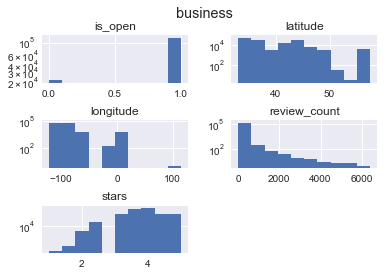

In [6]:
cols = ['review_count', 'stars', 'is_open', 'latitude', 'longitude']
axes = df_bus.hist(column=cols)
for i in axes:
    for ax in i:
        ax.set_yscale('log')

plt.subplots_adjust(hspace=0.8)
plt.suptitle('business')
plt.show()

# business per city
#v = df_bus.groupby('city').size()#.value_counts()
#print(v)
#sns.lmplot('latitude', 'longitude', data=df_bus, fit_reg=False)
#ax = sns.barplot(x=np.array(v.keys()), y=v.values, palette="BuGn_d")
#ax.set_yscale('log') 


In [7]:
import gmaps
from api import api
gmaps.configure(api_key=api)
fig = gmaps.figure()
heatmap_layer = gmaps.heatmap_layer(df_bus[['latitude', 'longitude']])
fig.add_layer(heatmap_layer)
#fig

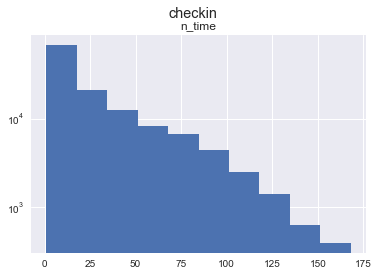

In [8]:
cols = ['n_time']
axes = df_checkin.hist(column=cols)
for i in axes:
    for ax in i:
        ax.set_yscale('log')

plt.subplots_adjust(hspace=0.8)
plt.suptitle('checkin')
plt.show()

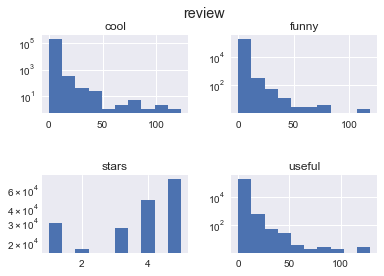

In [9]:
cols = ['stars', 'cool', 'funny', 'useful']
axes = df_review.hist(column=cols)
for i in axes:
    for ax in i:
        ax.set_yscale('log')

plt.subplots_adjust(hspace=0.8)
plt.suptitle('review')
plt.show()

# reviews per user: see under user
# reviews per business: see under business

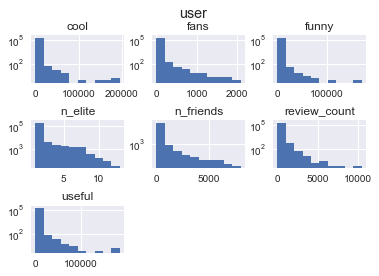

In [10]:
cols = ['review_count', 'n_friends', 'useful', 'funny', 'cool', 'fans', 'n_elite', 'type']
axes = df_user.hist(column=cols)
for i in axes:
    for ax in i:
        ax.set_yscale('log')

plt.subplots_adjust(hspace=0.8)
plt.suptitle('user')
plt.show()

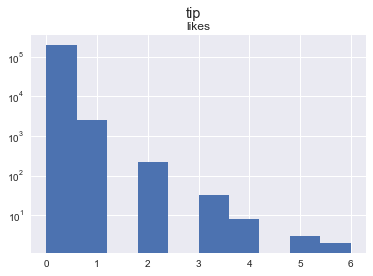

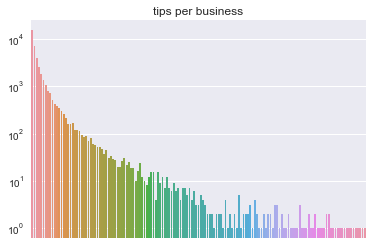

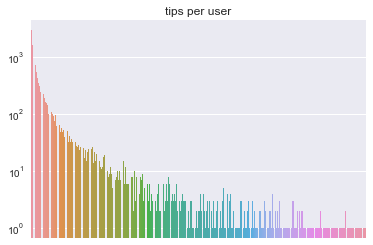

In [11]:
cols = ['likes']
axes = df_tip.hist(column=cols)
for i in axes:
    for ax in i:
        ax.set_yscale('log')

plt.subplots_adjust(hspace=0.8)
plt.suptitle('tip')
plt.show()

# Tips per business
t = df_tip.groupby('business_id').size().value_counts()
ax = sns.barplot(x=np.array(t.keys()), y=t.values)
ax.set_yscale('log')
ax.xaxis.set_ticklabels([])
plt.title('tips per business')
plt.show()

# Tips per user
t = df_tip.groupby('user_id').size().value_counts()
ax = sns.barplot(x=np.array(t.keys()), y=t.values)
ax.set_yscale('log')
ax.xaxis.set_ticklabels([])
plt.title('tips per user')
plt.show()

## Questions
How well can you guess a review's rating from its text alone? Can you take all of the reviews of a business and predict when it will be the most busy, or when the business is open? Can you predict if a business is good for kids? Has WiFi? Has Parking? What makes a review useful, funny, or cool? Can you figure out which business a user is likely to review next? How much of a business's success is really just location, location, location? What businesses deserve their own subcategory (i.e., Szechuan or Hunan versus just “Chinese restaurants”), and can you learn this from the review text? What are the differences between the cities in the dataset?

Can you take all of the reviews of a business and predict when it will be the most busy, or when the business is open?

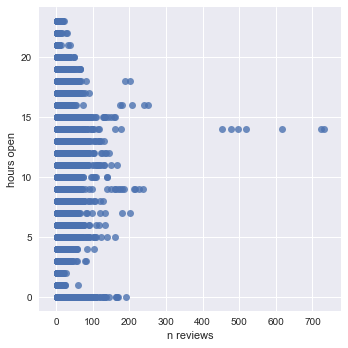

In [35]:
# prepare data
reviews = df_review[df_review['date'] > datetime(2015, 1, 1)]
#reviews = df_review
reviews = reviews.groupby(['business_id', 'weekday']).size().to_frame('n_reviews').reset_index()
reviews = reviews.merge(df_bus[['business_id', 'opening_hours', 'is_open']])
reviews['hours_open'] = reviews.apply(lambda x: x['opening_hours'][x['weekday']], axis=1)    
def is_open(hours):
    if hours > 0: return 1
    else: return 0
reviews['open'] = reviews['hours_open'].apply(is_open)

# Only take businesses with reviews
reviews = reviews[(reviews['n_reviews']>0)]

sns.lmplot('n_reviews', 'hours_open', data=reviews,
           fit_reg=False)
plt.ylabel('hours open')
plt.xlabel('n reviews')
plt.show()

#reviews.groupby('open').size()
#reviews.corr()

Data prepared. Rows: 201556
R^2: 0.071
Explained var: 0.071995


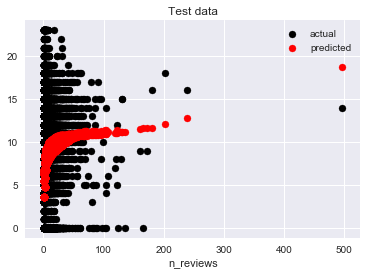

In [36]:
# split data
X = reviews[['weekday', 'n_reviews']]
y = reviews['hours_open']

print('Data prepared. Rows: {}'.format(len(X)))
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=999)        

# train model
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, explained_variance_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.svm import NuSVR

model = Pipeline([
    ('scaler', StandardScaler()),
#    ('learner', LogisticRegression())
#    ('classifier', MLPClassifier())
    ('regressor', MLPRegressor(alpha=0.01, hidden_layer_sizes=(100, 100)))
 #   ('regressor', NuSVR())
])

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("R^2: %1.3f" % r2_score(y_test, y_pred))
print("Explained var: {:3f}".format(explained_variance_score(y_test, y_pred)))
if 'classifier' in model.named_steps:
    print(classification_report(y_test, y_pred))
    
X_res = X_test['n_reviews']
plt.scatter(X_res, y_test, color='black', label='actual')
plt.scatter(X_res, y_pred, color='red', label='predicted')
plt.xlabel('n_reviews')
plt.legend(); plt.title('Test data')
plt.show()

if False:
    st = time()
    from sklearn.model_selection import GridSearchCV
    print('Start cv grid search...')
    params = {
        'regressor__hidden_layer_sizes': [(100,), (100, 100), (100, 50)],
        'regressor__alpha': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
       # 'regressor__degree': [2, 3, 4],
       # 'regressor__C': [1e-2, 1e-1, 1, 1e1, 1e2]
    }

    grid = GridSearchCV(model, cv=3, n_jobs=-1, param_grid=params)
    grid.fit(X_train, y_train)
    
    print(grid.best_estimator_.named_steps['regressor'])
    print('Done in {} s'.format(time() - st))

Can you predict if a business is good for kids? Has WiFi? Has Parking?

In [ ]:
# TODO
# add text analysis, probably with NLTK for low feature elimination etc.
# use more data, the models improve slightly with it, at least try a big run once
